# 73-缩小和放大

将imori.jpg进行灰度化处理之后，先缩小至原来的$0.5$倍，再放大两倍吧。这样做的话，会得到模糊的图像。

放大缩小的时候使用双线性插值。如果将双线性插值方法编写成函数的话，编程会变得简洁一些。

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img = cv2.imread('../picture/chan.jpg').astype(np.float32)

In [3]:
def BGR2GRAY(img):

    gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
    
    return gray

In [4]:
def bl_interpolate(img, ax, ay):
    
    if len(img.shape) > 2:
        H, W, C = img.shape
    else:
        H, W = img.shape
        C = 1
        
    aH = int(ay * H)
    aW = int(ax * W)

    # get position of resized image
    y = np.arange(aH).repeat(aW).reshape(aW, -1)
    x = np.tile(np.arange(aW), (aH, 1))

    # get position of original position
    y = (y / ay)
    x = (x / ax)
    
    ix = np.floor(x).astype(np.int)
    iy = np.floor(y).astype(np.int)
    
    ix = np.minimum(ix, W-2)
    iy = np.minimum(iy, H-2)
    
    # get distance 
    dx = x - ix
    dy = y - iy
    
    if C > 1:
        dx = np.repeat(np.expand_dims(dx, axis=-1), C, axis=-1)
        dy = np.repeat(np.expand_dims(dy, axis=-1), C, axis=-1)

    # interpolation
    out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out

In [5]:
gray = BGR2GRAY(img)

In [10]:
out = bl_interpolate(gray.astype(np.float32), ax=0.5, ay=0.5)

out = bl_interpolate(out, ax=2., ay=2.)

out = out.astype(np.uint8)

In [11]:
cv2.imwrite("../picture/result73_zoom_out_in.jpg", out)
cv2.imshow("result", out)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 74-使用差分金字塔提取高频成分

求出问题七十三中得到的图像与原图像的差，并将其正规化至$[0,255]$​范围。

在这里求得的就是图像的边缘。即，图像的高频成分。

In [12]:
out = bl_interpolate(gray.astype(np.float32), ax=0.5, ay=0.5)

out = bl_interpolate(out, ax=2., ay=2.)

out = np.abs(out - gray)

out = out / out.max() * 255

out = out.astype(np.uint8)

In [ ]:
cv2.imwrite("../picture/result74_Difference pyramid.jpg", out)
cv2.imshow("result", out)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 75-高斯金字塔（Gaussian Pyramid）

在这里我们求出原图像$\frac{1}{2}$, $\frac{1}{4}$, $\frac{1}{8}$, $\frac{1}{16}$, $\frac{1}{32}$大小的图像。

像这样把原图像缩小之后（像金字塔一样）重叠起来的就被称为高斯金字塔。

这种高斯金字塔的方法现在仍然有效。高斯金字塔的方法也用于提高图像清晰度的超分辨率成像（Super-Resolution ）深度学习方法。

In [5]:
def make_pyramid(gray):
    
    pyramid = [gray]
    
    for i in range(1, 6):
        a = 2. ** i
        
        p = bl_interpolate(gray, ax=1./a, ay=1./a)
        
        pyramid.append(p)
        
    return pyramid

In [6]:
gray = BGR2GRAY(img)

In [9]:
pyramid = make_pyramid(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


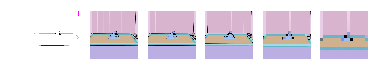

In [10]:
for i in range(6):
#     cv2.imwrite("../picture/result75_pyramid_{}.jpg".format(2**i), pyramid[i].astype(np.uint8))
    plt.subplot(1, 6, i+1)
    plt.imshow(pyramid[i], cmap='gray')
    plt.axis('off')
    plt.xticks(color="None")
    plt.yticks(color="None")

plt.savefig("../picture/result82_Harris.jpg")
plt.show()

# 76-显著图（Saliency Map）

在这里我们使用高斯金字塔制作简单的显著图。

显著图是将一副图像中容易吸引人的眼睛注意的部分（突出）表现的图像。

虽然现在通常使用深度学习的方法计算显著图，但是一开始人们用图像的RGB成分或者HSV成分创建高斯金字塔，并通过求差来得到显著图（例如Itti等人的方法）。

在这里我们使用在问题75中得到的高斯金字塔来简单地求出显著图。算法如下：

1. 我们使用双线性插值调整图像大小至$\frac{1}{128}$、 $\frac{1}{64}$、$\frac{1}{32}$……一开始是缩放至$\frac{1}{128}$。
2. 将得到的金字塔（我们将金字塔的各层分别编号为0,1,2,3,4,5）两两求差。
3. 将第2步中求得的差分全部相加，并正规化至$[0,255]$。

完成以上步骤就可以得到显著图了。虽然第2步中并没有指定要选择哪两张图像，但如果选择两个好的图像，则可以像答案那样得到一张显著图。

从图上可以清楚地看出，蝾螈的眼睛部分和颜色与周围不太一样的地方变成了白色，这些都是人的眼睛容易停留的地方。

解答中使用了$(0,1)$、$(0,3)$、$(0,5)$、$(1,4)$、$(2,3)$、$(3,5)$。

In [8]:
def makepyramid(gray):
    
    pyramid = [gray]
    
    for i in range(1, 6):
        
        a = 2. ** i
        
        p = bl_interpolate(gray, ax=1./a, ay=1./a)
        
        p = bl_interpolate(p, ax=a, ay=a)
        
        pyramid.append(p.astype(np.float32))
        
    return pyramid

In [10]:
def saliency_map(pyramid):

    H, W = pyramid[0].shape

    # prepare out image
    out = np.zeros((H, W), dtype=np.float32)

    # add each difference
    out += np.abs(pyramid[0] - pyramid[1])
    out += np.abs(pyramid[0] - pyramid[3])
    out += np.abs(pyramid[0] - pyramid[5])
    out += np.abs(pyramid[1] - pyramid[4])
    out += np.abs(pyramid[2] - pyramid[3])
    out += np.abs(pyramid[3] - pyramid[5])

    # normalization
    out = out / out.max() * 255

    return out

In [12]:
imge = cv2.imread('../picture/chans.png').astype(np.float32)

In [13]:
gray = BGR2GRAY(imge)

pyramid = makepyramid(gray)
    
out = saliency_map(pyramid)

out = out.astype(np.uint8)

In [ ]:
cv2.imwrite("../picture/result76_Saliency_Map.jpg", out)
cv2.imshow("result", out)
cv2.waitKey(0)
cv2.destroyAllWindows()